## A MongoDB Data Model

In [1]:
#{'_id': ObjectId('5cd419184a9d6f331e61cb12'),
# 'air_temperature_celcius': 17,
# 'date': datetime.datetime(2017, 12, 10, 0, 0),
# 'hot_spots': [{'confidence': 50,
#                'datetime': datetime.datetime(2017, 12, 10, 0, 57, 59),
#                'latitude': -37.986999999999995,
#                'longitude': 144.005,
#                'surface_temperature_celcius': 38},
#               {'confidence': 67,
#                'datetime': datetime.datetime(2017, 12, 10, 0, 56, 57),
#                'latitude': -34.289,
#                'longitude': 141.71200000000002,
#                'surface_temperature_celcius': 54}],
# 'max_wind_speed': 14.0,
# 'precipitation ': ' 0.00I',
# 'relative_humidity': 53.5,
# 'station': 948702,
# 'windspeed_knots': 7.3}

The example of our model is illustrated above. Climate has mandatory one to optional many relationship to hotsopt. To reduce the cost of JOIN operation, "hot_spots" object should be embedded in the "climate" object.

## B1 Load data to database

In [2]:
import pymongo
import gmplot
from pymongo import MongoClient
import pandas as pd #for data loading
import datetime
from pprint import pprint


In [3]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [4]:
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city

In [5]:
hotspotDf = pd.read_csv("hotspot_historic.csv") 
climateDf = pd.read_csv("climate_historic.csv") 
client = MongoClient()
db = client.fit5148_assignment_db
collection = db.climate

In [6]:
hotspotDf.head()

,latitude,longitude,datetime,confidence,date,surface_temperature_celcius
0,-37.966,145.051,2017-12-27T04:16:51,78,27/12/2017,68
1,-35.541,143.311,2017-12-27T00:02:15,82,27/12/2017,63
2,-35.554,143.307,2017-12-27T00:02:15,67,27/12/2017,53
3,-35.543,143.316,2017-12-27T00:02:14,86,27/12/2017,67
4,-37.708,145.100,2017-12-25T04:29:08,80,25/12/2017,54


In [7]:
climateDf.head()

,station,date,air_temperature_celcius,relative_humidity,windspeed_knots,max_wind_speed,precipitation
0,948700,31/12/2016,19,56.8,7.9,11.1,0.00I
1,948700,2/01/2017,15,50.7,9.2,13.0,0.02G
2,948700,3/01/2017,16,53.6,8.1,15.0,0.00G
3,948700,4/01/2017,24,61.6,7.7,14.0,0.00I
4,948700,5/01/2017,24,62.3,7.0,13.0,0.00I


In [8]:
for i in range(len(climateDf)):
    result = {}
    result['station']=int(climateDf.station[i])
    result["date"] = datetime.datetime.strptime(climateDf.date[i], "%d/%m/%Y")
    result["air_temperature_celcius"] = int(climateDf.air_temperature_celcius[i])
    result["relative_humidity"] = float(climateDf.relative_humidity[i])
    result["windspeed_knots"] = float(climateDf.windspeed_knots[i])
    result["max_wind_speed"] = float(climateDf.max_wind_speed[i])
    result["precipitation "] = climateDf.at[i, "precipitation "]
    
    hotspots = hotspotDf[hotspotDf.date==climateDf.date[i]]
    if len(hotspots) != 0:
        result["hot_spots"] = []
        for index, row in hotspots.iterrows():
            hotspot = {}
            hotspot["latitude"] = float(row.latitude)
            hotspot["longitude"] = float(row.longitude)
            hotspot["datetime"] = datetime.datetime.strptime(row.datetime,"%Y-%m-%dT%H:%M:%S")
            hotspot["confidence"] = int(row.confidence)
            hotspot["surface_temperature_celcius"] = int(row.surface_temperature_celcius)
            result["hot_spots"].append(hotspot)
                                      
    collection.insert_one(result)

In [9]:
#collection.drop()

In [10]:
date_list=[]
num_list=[]
results = collection.aggregate([
        {"$unwind":"$hot_spots"},
        {"$group":{"_id":"$date","count":{"$sum":1}}},
        {"$sort":{"count":pymongo.DESCENDING}},
        {"$limit":10}
        
])

for i in results :
    
    #print(i)
    date_list.append(i["_id"].strftime("%Y-%m-%d"))
    num_list.append(i["count"])
print(date_list)
print(num_list)




['2017-04-13', '2017-04-18', '2017-05-04', '2017-04-06', '2017-05-10', '2017-05-15', '2017-04-04', '2017-04-03', '2017-04-15', '2017-04-12']
[357, 325, 135, 118, 114, 102, 89, 72, 69, 69]


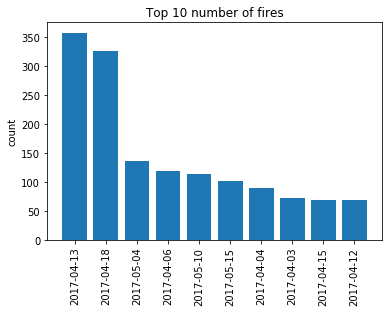

In [11]:
date = date_list
y_pos = np.arange(len(date))
performance = num_list

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, date)
plt.ylabel('count')
plt.title('Top 10 number of fires')
plt.xticks(rotation=90)
plt.show()

In [12]:
fire = []
a = collection.aggregate([{"$unwind":"$hot_spots"}])
for i in a:
    hot_spot = i['hot_spots'] 
    #pprint(i)
    information = "surface temp: " + str(hot_spot['surface_temperature_celcius']) + ", confidence: " + str(hot_spot['confidence']) + ", air temp: " + str(i['air_temperature_celcius']) + ", relative_humidity: " + str(i['relative_humidity'])
    
    fire.append((float(hot_spot['latitude']), float(hot_spot['longitude']), information))



# The step below is required by the gmap scatter function to prepare data in correct format
lats, lons, info = zip(*fire) 

In [13]:
# The step below is required by the gmap scatter function to prepare data in correct format
lats,lons,info = zip(*fire) 

# Plotting the points on the map
#gmap.scatter(lats,lons, '#FF4500', size=2, marker=True)
#gmap.scatter(lats, lons, '#FF6666', edge_width=10)

In [14]:
#print(fire)

In [15]:
#i[0] is lats, i[1]is lons and i[2]is information for the locations
for i in fire:
    gmap.marker(i[0],i[1],title=i[2])

In [16]:
import webbrowser
# Drawing the map
gmap.draw("map.html")
webbrowser.open_new("map.html")

True

## B2 Querying the database 

#### a. Find climate data on 10th December 2017

In [17]:
pprint(collection.find_one({"date":datetime.datetime(2017,12,10)}))



{'_id': ObjectId('5ce7b20ed9999f787bd85544'),
 'air_temperature_celcius': 17,
 'date': datetime.datetime(2017, 12, 10, 0, 0),
 'hot_spots': [{'confidence': 50,
                'datetime': datetime.datetime(2017, 12, 10, 0, 57, 59),
                'latitude': -37.986999999999995,
                'longitude': 144.005,
                'surface_temperature_celcius': 38},
               {'confidence': 67,
                'datetime': datetime.datetime(2017, 12, 10, 0, 56, 57),
                'latitude': -34.289,
                'longitude': 141.71200000000002,
                'surface_temperature_celcius': 54}],
 'max_wind_speed': 14.0,
 'precipitation ': ' 0.00I',
 'relative_humidity': 53.5,
 'station': 948702,
 'windspeed_knots': 7.3}


#### b. Find the latitude, longitude, surface temperature (°C), and confidence when the surface temperature (°C) was between 65 °C and 100 °C

In [18]:
results =collection.aggregate([{"$unwind":"$hot_spots"},
                              {"$match":{"$and":[{"hot_spots.surface_temperature_celcius":{"$gte":65}},
                                                {"hot_spots.surface_temperature_celcius":{"$lte":100}}]}},
                              {"$project":{"_id":0,"hot_spots.latitude":1,
                                          "hot_spots.longitude":1,
                                          "hot_spots.confidence":1,
                                          "hot_spots.surface_temperature_celcius":1}}])
                
for i in results:
    pprint(i)

{'hot_spots': {'confidence': 94,
               'latitude': -37.2284,
               'longitude': 147.9187,
               'surface_temperature_celcius': 73}}
{'hot_spots': {'confidence': 97,
               'latitude': -37.6572,
               'longitude': 142.0703,
               'surface_temperature_celcius': 80}}
{'hot_spots': {'confidence': 84,
               'latitude': -37.0193,
               'longitude': 148.1459,
               'surface_temperature_celcius': 71}}
{'hot_spots': {'confidence': 100,
               'latitude': -37.4229,
               'longitude': 147.02700000000002,
               'surface_temperature_celcius': 99}}
{'hot_spots': {'confidence': 80,
               'latitude': -37.0055,
               'longitude': 148.1582,
               'surface_temperature_celcius': 68}}
{'hot_spots': {'confidence': 85,
               'latitude': -37.4128,
               'longitude': 147.0242,
               'surface_temperature_celcius': 98}}
{'hot_spots': {'confidence': 90,
  

{'hot_spots': {'confidence': 96,
               'latitude': -36.6787,
               'longitude': 144.8042,
               'surface_temperature_celcius': 79}}
{'hot_spots': {'confidence': 84,
               'latitude': -38.0423,
               'longitude': 146.4048,
               'surface_temperature_celcius': 66}}
{'hot_spots': {'confidence': 94,
               'latitude': -38.1224,
               'longitude': 143.7553,
               'surface_temperature_celcius': 73}}
{'hot_spots': {'confidence': 94,
               'latitude': -38.0792,
               'longitude': 143.7361,
               'surface_temperature_celcius': 93}}
{'hot_spots': {'confidence': 93,
               'latitude': -37.9157,
               'longitude': 143.3544,
               'surface_temperature_celcius': 72}}
{'hot_spots': {'confidence': 96,
               'latitude': -37.7935,
               'longitude': 143.1606,
               'surface_temperature_celcius': 78}}
{'hot_spots': {'confidence': 90,
             

#### c. Find ​date,​ ​surface temperature (°C), air temperature (°C), relative humidity and max wind speed on​ 15th and 16th of December 2017.

In [19]:
results=collection.aggregate([
    {"$match":{"$or":[{"date":datetime.datetime(2017,12,15)},{"date":datetime.datetime(2017,12,16)}]}},
                               {"$project":{"date":1,"_id":0,"air_temperature_celcius":1,"relative_humidity":1,
                                           "max_wind_speed":1,"hot_spots.surface_temperature_celcius":1}}
     ])
for i in results:
    pprint(i)

{'air_temperature_celcius': 18,
 'date': datetime.datetime(2017, 12, 15, 0, 0),
 'hot_spots': [{'surface_temperature_celcius': 42},
               {'surface_temperature_celcius': 36},
               {'surface_temperature_celcius': 38},
               {'surface_temperature_celcius': 40}],
 'max_wind_speed': 14.0,
 'relative_humidity': 52.0}
{'air_temperature_celcius': 18,
 'date': datetime.datetime(2017, 12, 16, 0, 0),
 'hot_spots': [{'surface_temperature_celcius': 43},
               {'surface_temperature_celcius': 33},
               {'surface_temperature_celcius': 54},
               {'surface_temperature_celcius': 73},
               {'surface_temperature_celcius': 55},
               {'surface_temperature_celcius': 75},
               {'surface_temperature_celcius': 55},
               {'surface_temperature_celcius': 66},
               {'surface_temperature_celcius': 56},
               {'surface_temperature_celcius': 60},
               {'surface_temperature_celcius': 73},
      

#### d. Find ​datetime, air temperature (°C), surface temper and confidence when the confidence is between 80 and 100

In [20]:
results =collection.aggregate([
    {"$unwind":"$hot_spots"},
    {"$match":{"$and":
               [{"hot_spots.confidence":{"$gte":80}},
                {"hot_spots.confidence":{"$lte":100}}]}},
    {"$project": {"hot_spots.datetime":1, 
                  "air_temperature_celcius": 1, 
                  "hot_spots.surface_temperature_celcius": 1, 
                  "hot_spots.confidence":1,
                  "_id":0
    }}    
])

for i in results:
    pprint(i)

{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 3, 6, 5, 6, 30),
               'surface_temperature_celcius': 62}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 85,
               'datetime': datetime.datetime(2017, 3, 6, 5, 6, 20),
               'surface_temperature_celcius': 59}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 3, 7, 4, 16, 10),
               'surface_temperature_celcius': 64}}
{'air_temperature_celcius': 23,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 3, 9, 13, 23, 40),
               'surface_temperature_celcius': 41}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 3, 10, 4, 48, 40),
               'surface_temperature_celcius': 105}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 100,
       

               'surface_temperature_celcius': 55}}
{'air_temperature_celcius': 23,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 3, 26, 4, 39, 10),
               'surface_temperature_celcius': 62}}
{'air_temperature_celcius': 23,
 'hot_spots': {'confidence': 84,
               'datetime': datetime.datetime(2017, 3, 26, 4, 39, 10),
               'surface_temperature_celcius': 58}}
{'air_temperature_celcius': 18,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 3, 28, 4, 38),
               'surface_temperature_celcius': 64}}
{'air_temperature_celcius': 18,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 3, 28, 4, 33, 40),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 18,
 'hot_spots': {'confidence': 92,
               'datetime': datetime.datetime(2017, 3, 28, 4, 33, 30),
               'surface_temperature_celcius': 71}}
{'air_temperature_celci

 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2017, 4, 3, 3, 57, 50),
               'surface_temperature_celcius': 72}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 82,
               'datetime': datetime.datetime(2017, 4, 3, 3, 56, 20),
               'surface_temperature_celcius': 55}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 4, 3, 3, 55, 10),
               'surface_temperature_celcius': 64}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 95,
               'datetime': datetime.datetime(2017, 4, 3, 3, 55, 10),
               'surface_temperature_celcius': 77}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 96,
               'datetime': datetime.datetime(2017, 4, 3, 3, 54),
               'surface_temperature_celcius': 78}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(

{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 91,
               'datetime': datetime.datetime(2017, 4, 8, 4, 12, 50),
               'surface_temperature_celcius': 69}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 8, 4, 12, 20),
               'surface_temperature_celcius': 94}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 80,
               'datetime': datetime.datetime(2017, 4, 8, 4, 12),
               'surface_temperature_celcius': 59}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 98,
               'datetime': datetime.datetime(2017, 4, 8, 4, 8, 50),
               'surface_temperature_celcius': 83}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 90,
               'datetime': datetime.datetime(2017, 4, 8, 4, 8, 30),
               'surface_temperature_celcius': 66}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 80,
               

               'surface_temperature_celcius': 54}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 4, 13, 4, 27, 20),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 13, 4, 27, 20),
               'surface_temperature_celcius': 95}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 90,
               'datetime': datetime.datetime(2017, 4, 13, 4, 27, 20),
               'surface_temperature_celcius': 67}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 13, 4, 27, 20),
               'surface_temperature_celcius': 92}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 4, 13, 4, 27, 20),
               'surface_temperature_celcius': 64}}
{'air_temperature

 'hot_spots': {'confidence': 97,
               'datetime': datetime.datetime(2017, 4, 13, 4, 26, 30),
               'surface_temperature_celcius': 81}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 4, 13, 4, 26, 30),
               'surface_temperature_celcius': 61}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 91,
               'datetime': datetime.datetime(2017, 4, 13, 4, 26, 30),
               'surface_temperature_celcius': 80}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 81,
               'datetime': datetime.datetime(2017, 4, 13, 4, 26, 30),
               'surface_temperature_celcius': 55}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 13, 4, 26, 30),
               'surface_temperature_celcius': 93}}
{'air_temperature_celcius': 16,
 'hot_spots': {'confidence': 100,
               'datetime': datetime

               'datetime': datetime.datetime(2017, 4, 18, 4, 52, 20),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 18, 4, 52),
               'surface_temperature_celcius': 124}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 85,
               'datetime': datetime.datetime(2017, 4, 18, 4, 52),
               'surface_temperature_celcius': 59}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2017, 4, 18, 4, 51, 40),
               'surface_temperature_celcius': 72}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 80,
               'datetime': datetime.datetime(2017, 4, 18, 4, 51, 30),
               'surface_temperature_celcius': 53}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 89,
               'datetime': datetime.datetime(2017, 4, 18, 4, 51, 30),
      

{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 61}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 94,
               'datetime': datetime.datetime(2017, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 93}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 114}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 62}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2017, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 72}}
{'air_temperature_celcius': 15,
 'hot_spots': {'confidence': 81,
   

               'surface_temperature_celcius': 62}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 4, 20, 0, 18, 40),
               'surface_temperature_celcius': 63}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 4, 20, 0, 18, 20),
               'surface_temperature_celcius': 111}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 99,
               'datetime': datetime.datetime(2017, 4, 20, 0, 17, 10),
               'surface_temperature_celcius': 85}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 96,
               'datetime': datetime.datetime(2017, 4, 20, 0, 14, 10),
               'surface_temperature_celcius': 78}}
{'air_temperature_celcius': 20,
 'hot_spots': {'confidence': 89,
               'datetime': datetime.datetime(2017, 4, 20, 0, 13, 40),
               'surface_temperature_celcius': 64}}
{'air_temperature

 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2017, 5, 3, 4, 2, 40),
               'surface_temperature_celcius': 73}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 96,
               'datetime': datetime.datetime(2017, 5, 3, 4, 2, 20),
               'surface_temperature_celcius': 79}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 5, 3, 4, 2, 20),
               'surface_temperature_celcius': 94}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 5, 3, 4, 2, 20),
               'surface_temperature_celcius': 64}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 84,
               'datetime': datetime.datetime(2017, 5, 3, 4, 2, 20),
               'surface_temperature_celcius': 58}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2

               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
               'surface_temperature_celcius': 78}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
               'surface_temperature_celcius': 62}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
               'surface_temperature_celcius': 61}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 94,
               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
               'surface_temperature_celcius': 74}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 82,
               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
               'surface_temperature_celcius': 55}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 87,
               'datetime': datetime.datetime(2017, 5, 10, 4, 8, 10),
      

{'air_temperature_celcius': 9,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 5, 13, 4, 38, 40),
               'surface_temperature_celcius': 95}}
{'air_temperature_celcius': 9,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 5, 13, 4, 38, 40),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 9,
 'hot_spots': {'confidence': 85,
               'datetime': datetime.datetime(2017, 5, 13, 4, 38, 40),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 93,
               'datetime': datetime.datetime(2017, 5, 15, 4, 34, 30),
               'surface_temperature_celcius': 73}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 96,
               'datetime': datetime.datetime(2017, 5, 15, 4, 34, 30),
               'surface_temperature_celcius': 78}}
{'air_temperature_celcius': 10,
 'hot_spots': {'confidence': 83,
       

               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 11,
 'hot_spots': {'confidence': 81,
               'datetime': datetime.datetime(2017, 9, 10, 3, 50, 10),
               'surface_temperature_celcius': 54}}
{'air_temperature_celcius': 14,
 'hot_spots': {'confidence': 89,
               'datetime': datetime.datetime(2017, 9, 20, 4, 29, 3),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 14,
 'hot_spots': {'confidence': 100,
               'datetime': datetime.datetime(2017, 9, 20, 4, 29, 3),
               'surface_temperature_celcius': 112}}
{'air_temperature_celcius': 14,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 9, 20, 4, 28, 45),
               'surface_temperature_celcius': 60}}
{'air_temperature_celcius': 17,
 'hot_spots': {'confidence': 86,
               'datetime': datetime.datetime(2017, 9, 23, 23, 50, 44),
               'surface_temperature_celcius': 56}}
{'air_temperature_

 'hot_spots': {'confidence': 80,
               'datetime': datetime.datetime(2017, 10, 4, 4, 41, 2),
               'surface_temperature_celcius': 46}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 80,
               'datetime': datetime.datetime(2017, 10, 4, 4, 41),
               'surface_temperature_celcius': 46}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 85,
               'datetime': datetime.datetime(2017, 10, 4, 4, 41),
               'surface_temperature_celcius': 54}}
{'air_temperature_celcius': 19,
 'hot_spots': {'confidence': 88,
               'datetime': datetime.datetime(2017, 10, 4, 4, 41),
               'surface_temperature_celcius': 58}}
{'air_temperature_celcius': 17,
 'hot_spots': {'confidence': 91,
               'datetime': datetime.datetime(2017, 10, 7, 12, 59, 33),
               'surface_temperature_celcius': 42}}
{'air_temperature_celcius': 13,
 'hot_spots': {'confidence': 96,
               'datetime': datetime.datetime(2017

#### e. Find the top 10 records with the highest ​surface temperature​ ​(°C).

In [21]:
results = collection.aggregate([   
    {"$unwind":"$hot_spots"},
    {"$sort":{"hot_spots.surface_temperature_celcius":pymongo.DESCENDING}},
    {"$project":{"hot_spots.surface_temperature_celcius": 1,
                 "_id":0
    
    }},
    {"$limit":10}
       
])

for i in results:
    pprint(i)

{'hot_spots': {'surface_temperature_celcius': 124}}
{'hot_spots': {'surface_temperature_celcius': 123}}
{'hot_spots': {'surface_temperature_celcius': 122}}
{'hot_spots': {'surface_temperature_celcius': 121}}
{'hot_spots': {'surface_temperature_celcius': 120}}
{'hot_spots': {'surface_temperature_celcius': 120}}
{'hot_spots': {'surface_temperature_celcius': 120}}
{'hot_spots': {'surface_temperature_celcius': 120}}
{'hot_spots': {'surface_temperature_celcius': 120}}
{'hot_spots': {'surface_temperature_celcius': 119}}


####  f.  Find the number of fire in each day. You are required to only display ​the total number of fire​ a​ nd ​the date​ in the output.

In [22]:
results = collection.aggregate([
        {"$unwind":"$hot_spots"},
        {"$group":{"_id":"$date","count":{"$sum":1}}},
        {"$sort":{"count":pymongo.DESCENDING}}
])

for i in results:
    pprint(i)

{'_id': datetime.datetime(2017, 4, 13, 0, 0), 'count': 357}
{'_id': datetime.datetime(2017, 4, 18, 0, 0), 'count': 325}
{'_id': datetime.datetime(2017, 5, 4, 0, 0), 'count': 135}
{'_id': datetime.datetime(2017, 4, 6, 0, 0), 'count': 118}
{'_id': datetime.datetime(2017, 5, 10, 0, 0), 'count': 114}
{'_id': datetime.datetime(2017, 5, 15, 0, 0), 'count': 102}
{'_id': datetime.datetime(2017, 4, 4, 0, 0), 'count': 89}
{'_id': datetime.datetime(2017, 4, 3, 0, 0), 'count': 72}
{'_id': datetime.datetime(2017, 4, 12, 0, 0), 'count': 69}
{'_id': datetime.datetime(2017, 4, 15, 0, 0), 'count': 69}
{'_id': datetime.datetime(2017, 5, 3, 0, 0), 'count': 64}
{'_id': datetime.datetime(2017, 5, 13, 0, 0), 'count': 54}
{'_id': datetime.datetime(2017, 3, 28, 0, 0), 'count': 54}
{'_id': datetime.datetime(2017, 4, 19, 0, 0), 'count': 50}
{'_id': datetime.datetime(2017, 4, 5, 0, 0), 'count': 49}
{'_id': datetime.datetime(2017, 4, 7, 0, 0), 'count': 39}
{'_id': datetime.datetime(2017, 4, 17, 0, 0), 'count': 38

In [23]:
results = collection.aggregate([
        {"$unwind":"$hot_spots"},
        {"$group":{"_id":"$date","count":{"$sum":1}}},
        {"$sort":{"count":pymongo.DESCENDING}},
        {"$limit":10}
        
])

for i in results:
    pprint(i)

{'_id': datetime.datetime(2017, 4, 13, 0, 0), 'count': 357}
{'_id': datetime.datetime(2017, 4, 18, 0, 0), 'count': 325}
{'_id': datetime.datetime(2017, 5, 4, 0, 0), 'count': 135}
{'_id': datetime.datetime(2017, 4, 6, 0, 0), 'count': 118}
{'_id': datetime.datetime(2017, 5, 10, 0, 0), 'count': 114}
{'_id': datetime.datetime(2017, 5, 15, 0, 0), 'count': 102}
{'_id': datetime.datetime(2017, 4, 4, 0, 0), 'count': 89}
{'_id': datetime.datetime(2017, 4, 3, 0, 0), 'count': 72}
{'_id': datetime.datetime(2017, 4, 15, 0, 0), 'count': 69}
{'_id': datetime.datetime(2017, 4, 12, 0, 0), 'count': 69}


#### g.  Find the ​average surface temperature ​(°C) f​ or each day​. You are required to only display ​average surface temperature (°C)​ ​and ​the date​ in the output.

In [25]:
results = collection.aggregate([
        {"$unwind":"$hot_spots"},
        {"$group":{"_id":"$date","avg": 
                  {"$avg": "$hot_spots.surface_temperature_celcius"}}},
    {"$sort":{"avg":pymongo.DESCENDING}}
])

for i in results:
    pprint(i)

{'_id': datetime.datetime(2017, 3, 12, 0, 0), 'avg': 88.2}
{'_id': datetime.datetime(2017, 3, 18, 0, 0), 'avg': 79.33333333333333}
{'_id': datetime.datetime(2017, 10, 15, 0, 0), 'avg': 72.66666666666667}
{'_id': datetime.datetime(2017, 6, 20, 0, 0), 'avg': 71.16666666666667}
{'_id': datetime.datetime(2017, 12, 14, 0, 0), 'avg': 70.0}
{'_id': datetime.datetime(2017, 3, 10, 0, 0), 'avg': 69.375}
{'_id': datetime.datetime(2017, 5, 1, 0, 0), 'avg': 68.4}
{'_id': datetime.datetime(2017, 3, 25, 0, 0), 'avg': 66.0}
{'_id': datetime.datetime(2017, 3, 14, 0, 0), 'avg': 65.6}
{'_id': datetime.datetime(2017, 3, 19, 0, 0), 'avg': 65.57142857142857}
{'_id': datetime.datetime(2017, 3, 7, 0, 0), 'avg': 64.0}
{'_id': datetime.datetime(2017, 9, 20, 0, 0), 'avg': 63.6}
{'_id': datetime.datetime(2017, 8, 2, 0, 0), 'avg': 63.5}
{'_id': datetime.datetime(2017, 8, 10, 0, 0), 'avg': 63.0}
{'_id': datetime.datetime(2017, 4, 29, 0, 0), 'avg': 63.0}
{'_id': datetime.datetime(2017, 12, 27, 0, 0), 'avg': 62.75}
{